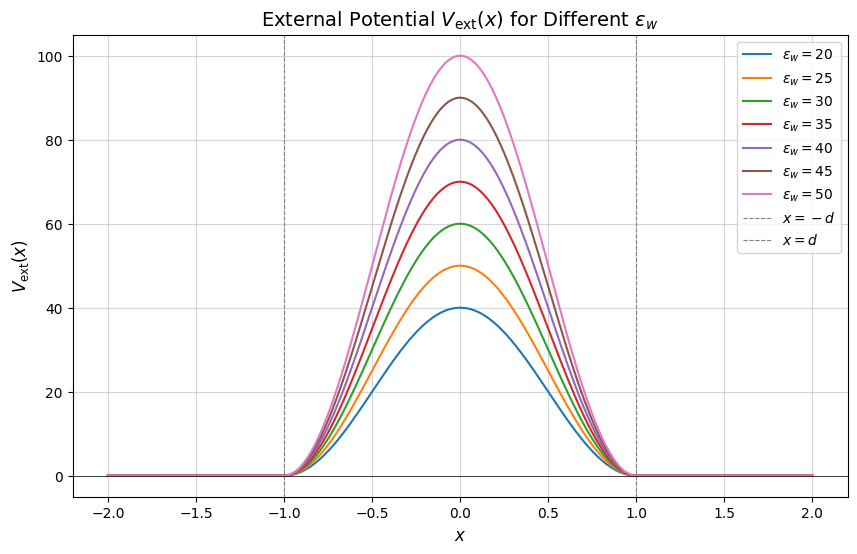

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sigma = 1.0  # Particle diameter
d = sigma    # Barrier width
ew_values = np.arange(20, 55, 5)  # Barrier strength values from 20 to 50 incrementing by 5

# Define the potential function
def V_ext(x, epsilon_w, d):
    H = lambda x: np.heaviside(x, 0.5)  # Heaviside step function
    return epsilon_w * (np.cos(np.pi * x / d) + 1) * H(d - x) * H(x + d)

# x range
x = np.linspace(-2 * d, 2 * d, 500)

# Plot
plt.figure(figsize=(10, 6))
for ew in ew_values:
    V = V_ext(x, ew, d)
    plt.plot(x, V, label=f"$\\epsilon_w = {ew}$")

plt.axvline(-d, color='gray', linestyle='--', label=r"$x = -d$", linewidth=0.8)
plt.axvline(d, color='gray', linestyle='--', label=r"$x = d$", linewidth=0.8)
plt.axhline(0, color='black', linewidth=0.5)
plt.title("External Potential $V_{\\text{ext}}(x)$ for Different $\\epsilon_w$", fontsize=14)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$V_{\\text{ext}}(x)$", fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.5)
plt.show()

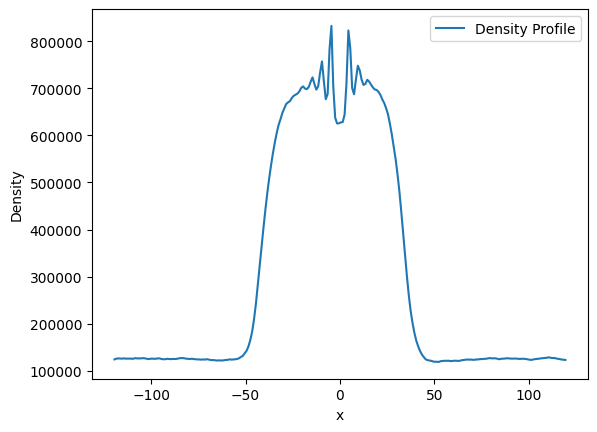

Asymmetry Order Parameter: 0.17748352034959078


ValueError: max() arg is an empty sequence

In [8]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Load trajectory data
def load_trajectory(filename):
    data = []
    with gzip.open(filename, 'rt') as f:
        record = False
        for line in f:
            if "ITEM: ATOMS" in line:
                record = True
                continue
            elif "ITEM:" in line:
                record = False
            elif record:
                try:
                    data.append([float(x) for x in line.split()])
                except ValueError:
                    break
    return np.array(data)

# Compute density profile along x-axis
def density_profile(data, lx, bin_size=1.0):
    bins = np.arange(-lx, lx + bin_size, bin_size)
    hist, _ = np.histogram(data[:, 1], bins=bins)
    density = hist / bin_size
    return density, bins[:-1] + bin_size / 2

# Compute asymmetry order parameter
def asymmetry_order_parameter(density, bins, lx):
    dx = bins[1] - bins[0]
    left = np.sum(density[bins < 0]) * dx
    right = np.sum(density[bins >= 0]) * dx
    rho = np.mean(density)
    rho_ld = np.min(density)  # Assuming lowest density as low-density phase
    return np.abs(right - left) / ((rho - rho_ld) * lx)

# Identify bubbles and calculate sizes
def bubble_sizes(data, lx, ly, threshold):
    grid_x = np.linspace(-lx, lx, int(2 * lx / threshold))
    grid_y = np.linspace(-ly, ly, int(2 * ly / threshold))
    hist, _, _ = np.histogram2d(data[:, 1], data[:, 2], bins=[grid_x, grid_y])
    binary = (hist < threshold).astype(int)
    labeled, num_features = label(binary)
    bubble_sizes = []
    for i in range(1, num_features + 1):
        bubble = (labeled == i)
        lx_bubble = np.sum(np.any(bubble, axis=1)) * threshold
        ly_bubble = np.sum(np.any(bubble, axis=0)) * threshold
        bubble_sizes.append((lx_bubble, ly_bubble))
    return bubble_sizes

# Compute compressibility profile
def compressibility_profile(data, bins, lx):
    dx = bins[1] - bins[0]
    profiles = []
    for i in range(0, len(data), len(data) // 10):  # Sample 10 snapshots
        hist, _ = np.histogram(data[i:i+len(data)//10, 1], bins=bins)
        profiles.append(hist / dx)
    profiles = np.array(profiles)
    mean_density = profiles.mean(axis=0)
    fluctuations = profiles.var(axis=0)
    compressibility = fluctuations / mean_density
    return compressibility

# Main analysis
filename = "dumps/stable/wet_ew_50.gz"
lx = 120.0
ly = 30.0

data = load_trajectory(filename)

# Density profile
density, bins = density_profile(data, lx)
plt.plot(bins, density, label="Density Profile")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

# Asymmetry Order Parameter
asymmetry = asymmetry_order_parameter(density, bins, lx)
print(f"Asymmetry Order Parameter: {asymmetry}")

# Bubble Size Analysis
bubble_threshold = 0.5
bubbles = bubble_sizes(data, lx, ly, bubble_threshold)
largest_bubble = max(bubbles, key=lambda x: x[0])
print(f"Largest Bubble: {largest_bubble}")

# Compressibility Profile
compressibility = compressibility_profile(data, bins, lx)
plt.plot(bins, compressibility, label="Compressibility Profile")
plt.xlabel("x")
plt.ylabel("Compressibility")
plt.legend()
plt.show()
